In [70]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_cluster_sequences(file_list, t=10, folder='.'):
    X_all, y_all = [], []
    for fname in file_list:
        df = pd.read_csv(os.path.join(folder, fname), sep=None, engine='python')
        df = df.iloc[1:]  # remove header
        df = df.apply(pd.to_numeric, errors='coerce').dropna()
        if df.shape[0] >= t + 1 and df.shape[1] == 13:
            scaler = StandardScaler()
            data = scaler.fit_transform(df.values)
            for i in range(len(data) - t):
                X_all.append(data[i:i + t])
                y_all.append(data[i + t])
    return np.array(X_all), np.array(y_all)  # shapes: (n_samples, t, 13), (n_samples, 13)


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_forecaster(timesteps=10, features=13):
    model = Sequential([
        LSTM(64, input_shape=(timesteps, features)),
        Dense(64, activation='relu'),
        Dense(features)  # Predict next 13D step
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout

def build_cnn_forecaster(timesteps=10, features=13):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, features)),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(features)  # Predict next 13D step
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [73]:
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

def build_cnn_forecaster(timesteps=10, features=13):
    """
    Enhanced CNN architecture with:
    - Deeper network
    - Better regularization
    - Batch normalization
    - Same input/output interface as original
    """
    model = Sequential([
        # Input Conv Block
        Conv1D(64, kernel_size=3, padding='same', input_shape=(timesteps, features)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv1D(64, kernel_size=3, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Middle Conv Block
        Conv1D(128, kernel_size=3, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Conv1D(128, kernel_size=3, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Final Conv Block
        Conv1D(256, kernel_size=3, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        
        # Dense Layers
        Flatten(),
        Dense(128, kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        
        Dense(64, kernel_regularizer=l1_l2(l1=1e-6, l2=1e-5)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        
        Dense(features)  # Output layer (same as original)
    ])
    
    # Enhanced optimizer with lower learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [74]:
import matplotlib.pyplot as plt

def plot_loss(history, title='Model Loss'):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [75]:
# Your cluster file lists (from earlier clustering)
cluster_1_files = cluster1  # 52 files
cluster_2_files = cluster2  # 46 files

# Hyperparameter: past time steps used for prediction
T = 10

# Load data for both clusters
X1, y1 = load_cluster_sequences(cluster_1_files, t=T)
X2, y2 = load_cluster_sequences(cluster_2_files, t=T)

print(f"Cluster 1 training pairs: {X1.shape}, {y1.shape}")
print(f"Cluster 2 training pairs: {X2.shape}, {y2.shape}")



Cluster 1 training pairs: (44505, 10, 13), (44505, 13)
Cluster 2 training pairs: (44505, 10, 13), (44505, 13)


In [76]:
# Build and train models
model_1_cnn = build_cnn_forecaster(timesteps=T, features=13)
model_2_cnn = build_cnn_forecaster(timesteps=T, features=13)

# Early stopping to prevent overfitting
es_cnn = EarlyStopping(patience=5, restore_best_weights=True)

history_1_cnn = model_1_cnn.fit(X1, y1, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es_cnn])
history_2_cnn = model_2_cnn.fit(X2, y2, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es_cnn])

# Save models
model_1_cnn.save("forecast_cluster1_cnn.keras", save_format='keras')
model_2_cnn.save("forecast_cluster2_cnn.keras", save_format='keras')

c:\Users\Shibin\miniconda3\envs\PAS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Shibin\miniconda3\envs\PAS\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.5163 - mae: 0.3907 - val_loss: 0.2778 - val_mae: 0.1300
Epoch 2/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.3389 - mae: 0.2166 - val_loss: 0.2700 - val_mae: 0.1145
Epoch 3/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3659 - mae: 0.1910 - val_loss: 0.2656 - val_mae: 0.1116
Epoch 4/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3354 - mae: 0.1791 - val_loss: 0.2665 - val_mae: 0.1152
Epoch 5/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2592 - mae: 0.1688 - val_loss: 0.2595 - val_mae: 0.0997
Epoch 6/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2997 - mae: 0.1680 - val_loss: 0.2612 - val_mae: 0.1086
Epoch 7/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2914 - mae: 0.1626 - val_loss: 0.2557 - val_mae: 0.0915
Epoch 8/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2903 - mae: 0.1601 - val_loss: 0.2540 - val_mae: 0.0901
Epoch 9/50
1113/1113 ━━━━━━━━━━━━━━━━━━

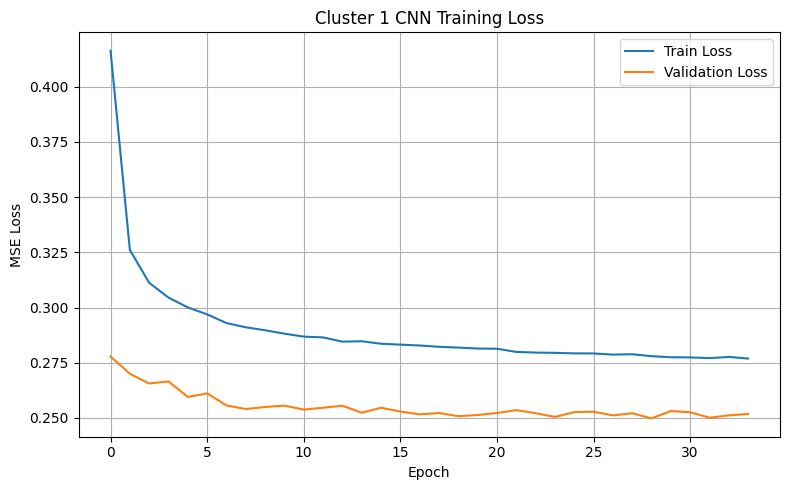

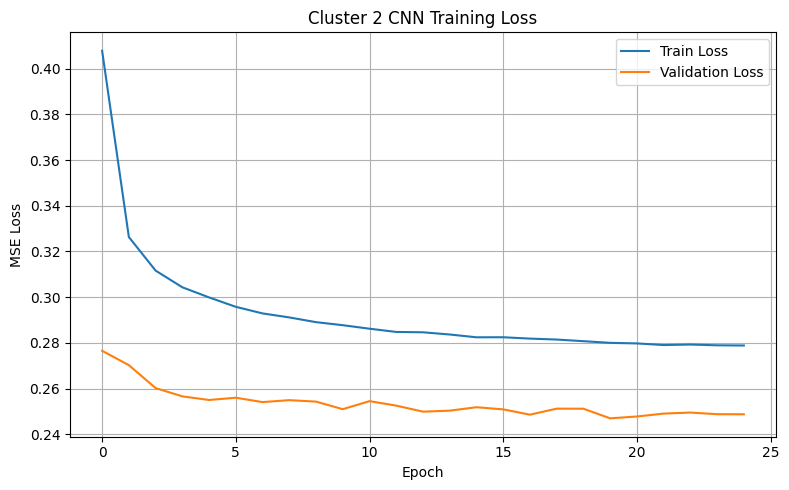

In [77]:
plot_loss(history_1_cnn, title='Cluster 1 CNN Training Loss')
plot_loss(history_2_cnn, title='Cluster 2 CNN Training Loss')


In [78]:
# Build and train models
model_1_lstm = build_lstm_forecaster(timesteps=T, features=13)
model_2_lstm = build_lstm_forecaster(timesteps=T, features=13)

# Early stopping to prevent overfitting
es_lstm = EarlyStopping(patience=5, restore_best_weights=True)

history_1_lstm = model_1_lstm.fit(X1, y1, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es_cnn])
history_2_lstm = model_2_lstm.fit(X2, y2, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es_cnn])

# Save models
model_1_lstm.save("forecast_cluster1_cnn.keras", save_format='keras')
model_2_lstm.save("forecast_cluster2_cnn.keras", save_format='keras')

Epoch 1/50


c:\Users\Shibin\miniconda3\envs\PAS\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3423 - val_loss: 0.2432
Epoch 2/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2405 - val_loss: 0.2416
Epoch 3/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2184 - val_loss: 0.2406
Epoch 4/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2218 - val_loss: 0.2420
Epoch 5/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2598 - val_loss: 0.2394
Epoch 6/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2618 - val_loss: 0.2399
Epoch 7/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2232 - val_loss: 0.2404
Epoch 8/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2281 - val_loss: 0.2390
Epoch 9/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2162 - val_loss: 0.2390
Epoch 10/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1841 - val_loss: 0.2396
Epoch 11/50
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2139 - val_loss: 0.2396
Epoch 12/50
1113/1113 ━━━━━━━━━━━━━━━━━━━

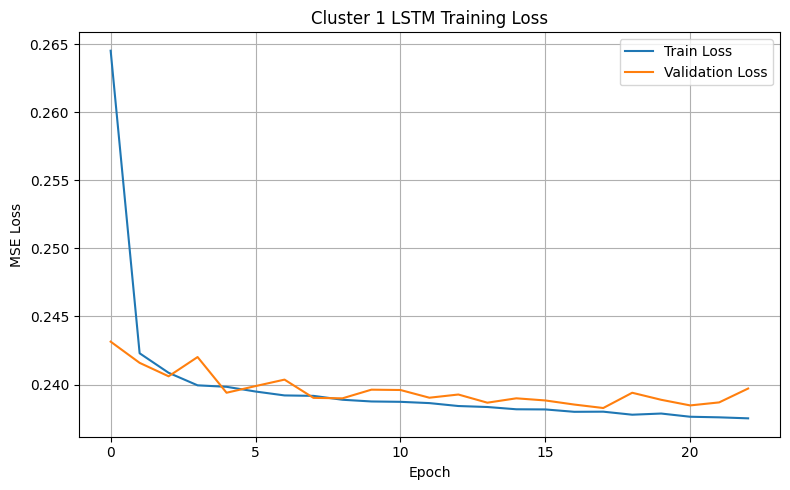

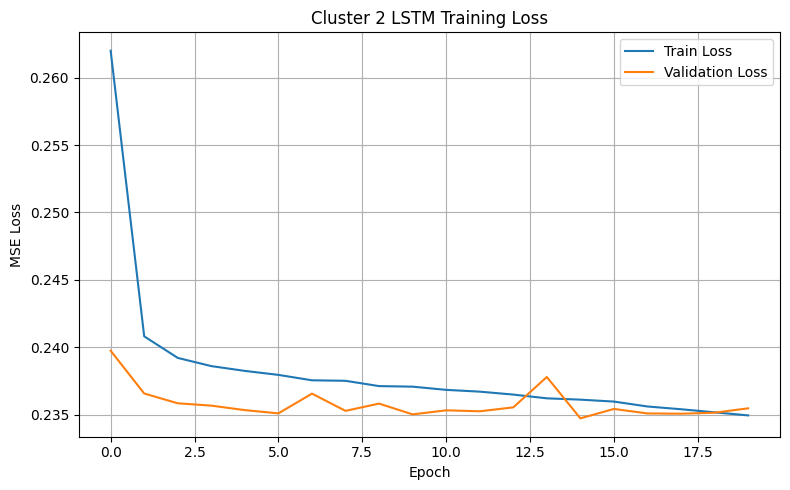

In [79]:
plot_loss(history_1_lstm, title='Cluster 1 LSTM Training Loss')
plot_loss(history_2_lstm, title='Cluster 2 LSTM Training Loss')


✅ Models loaded


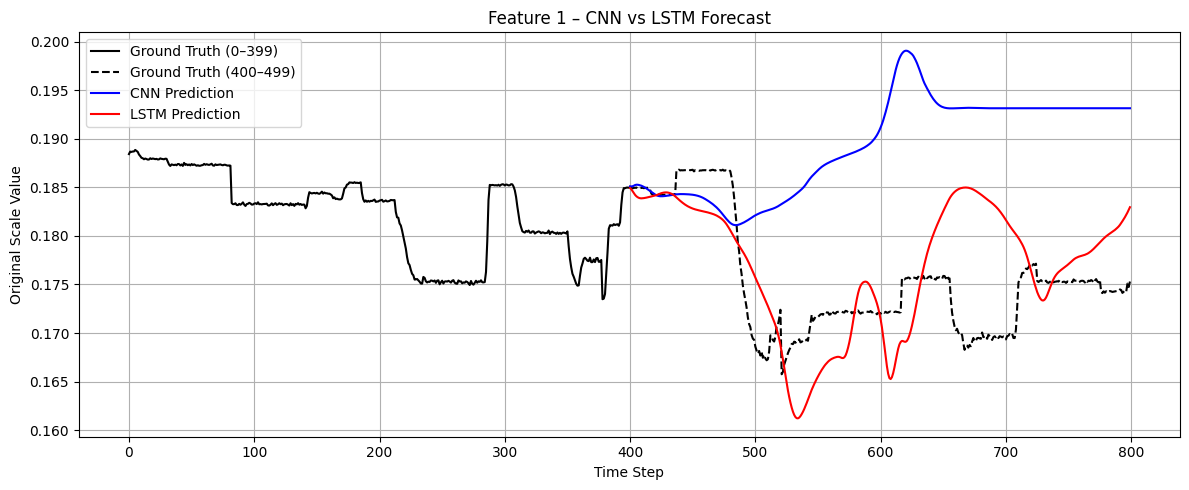

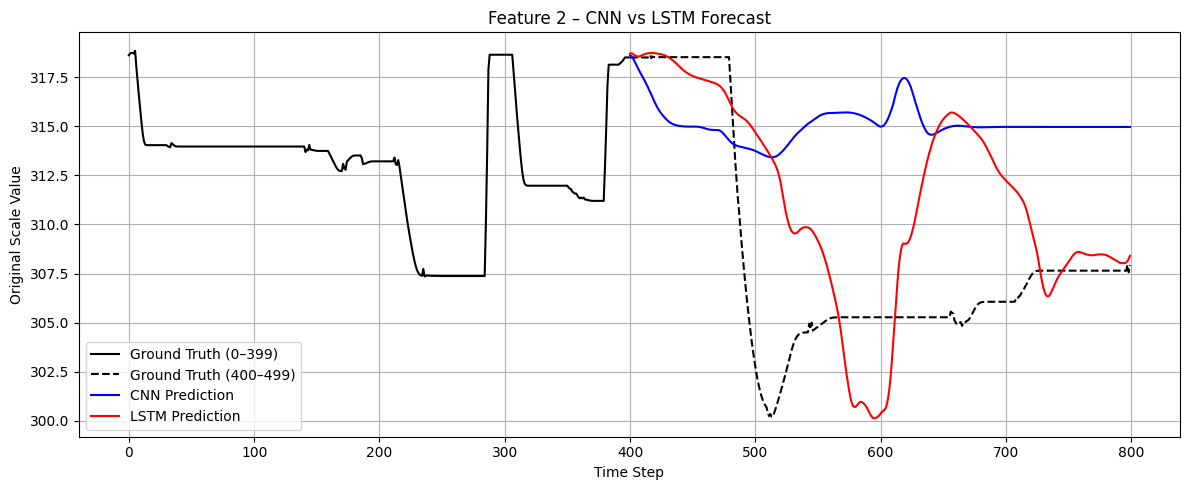

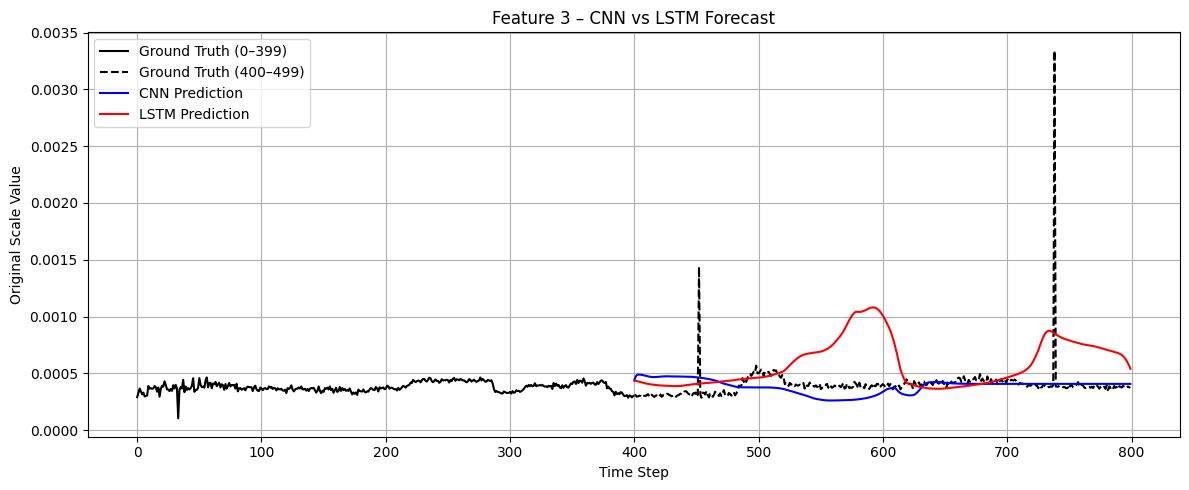

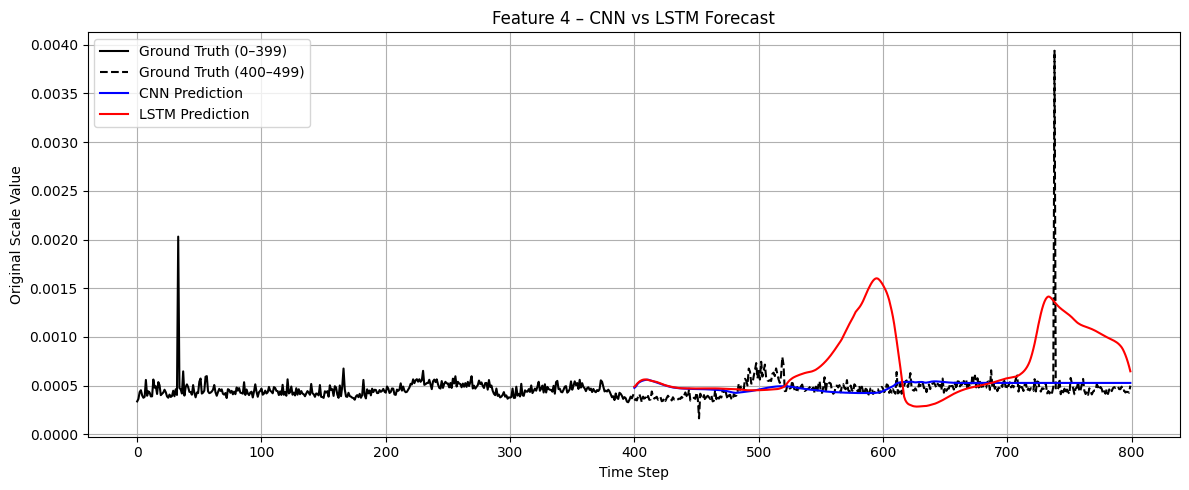

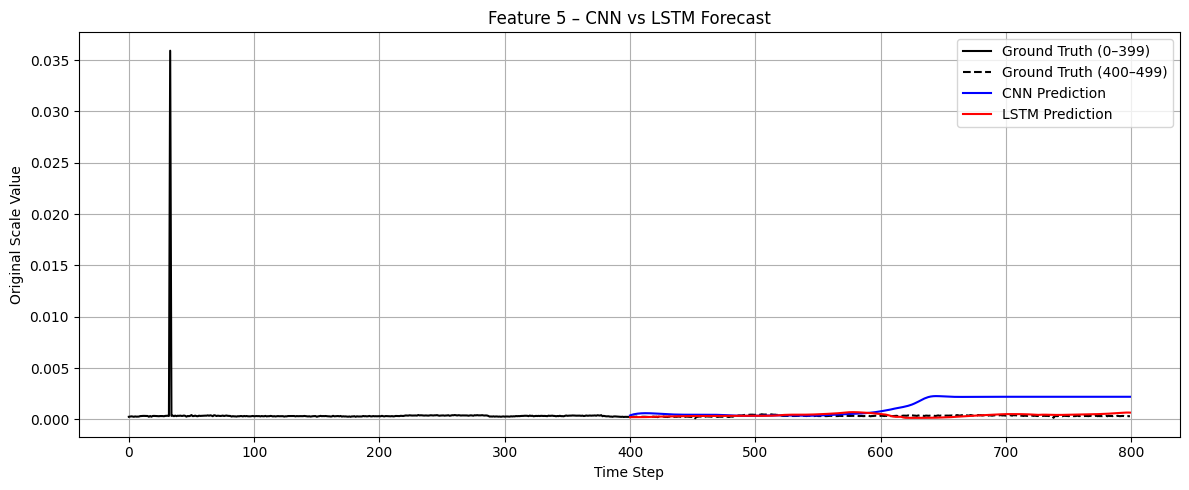

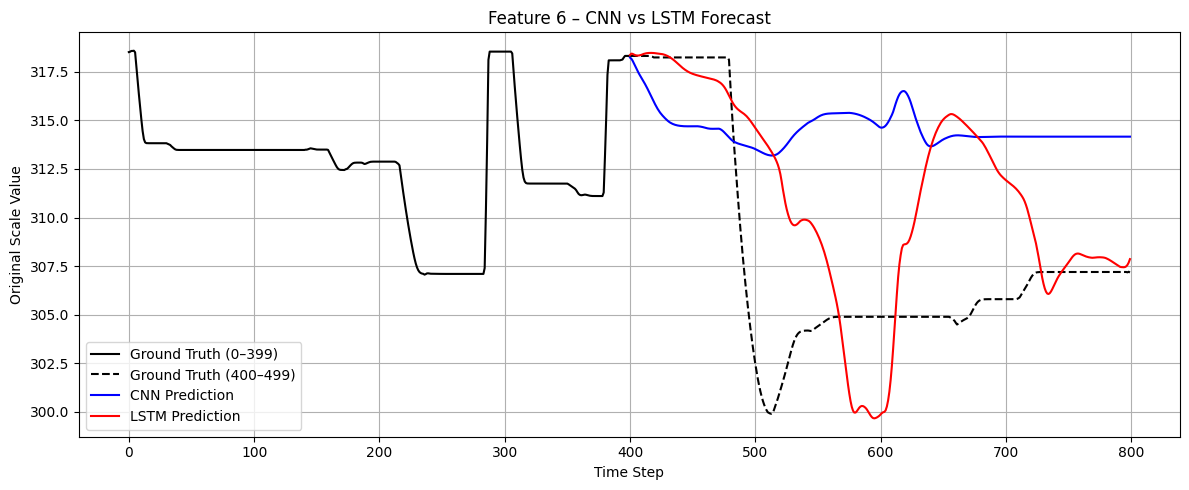

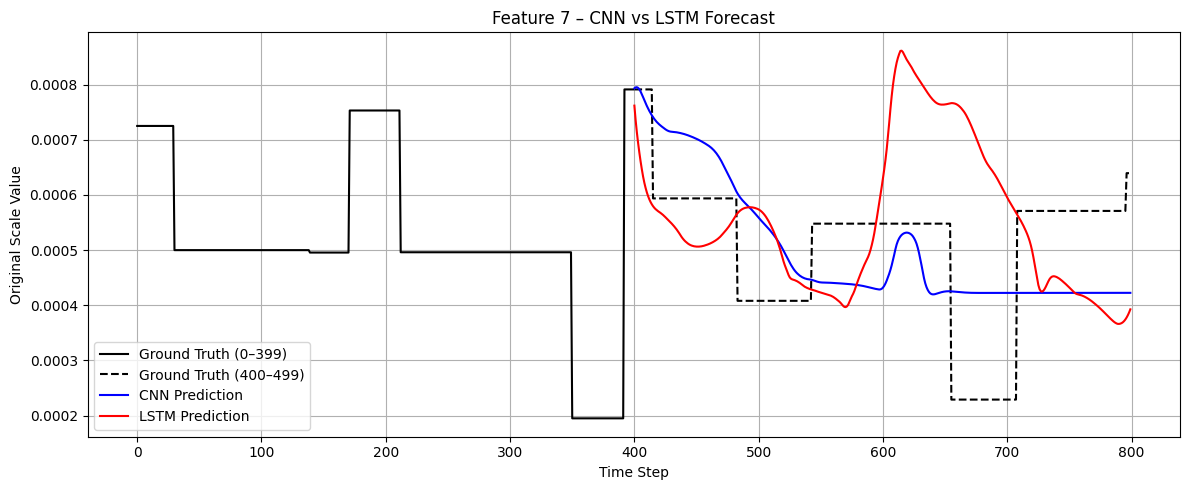

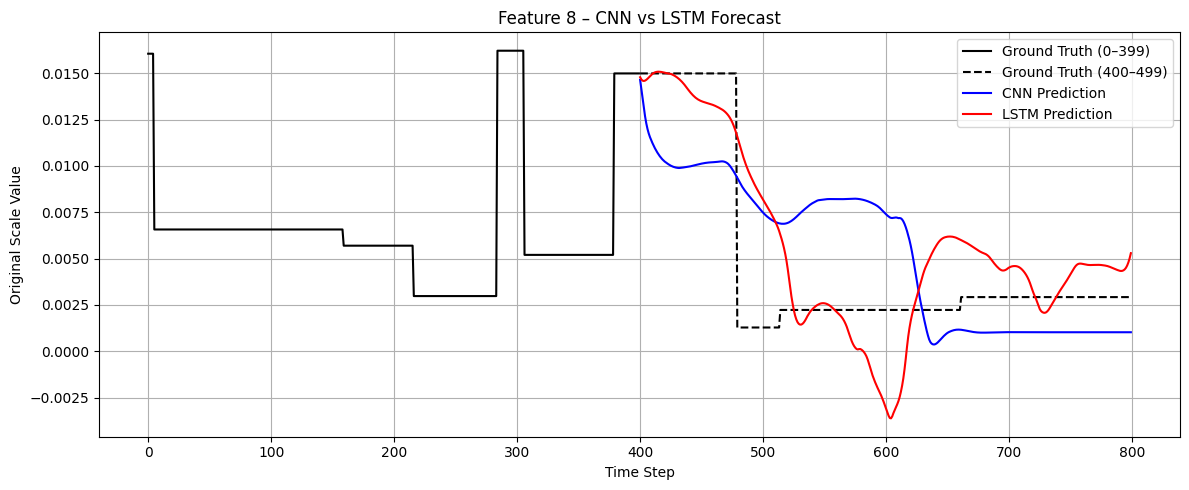

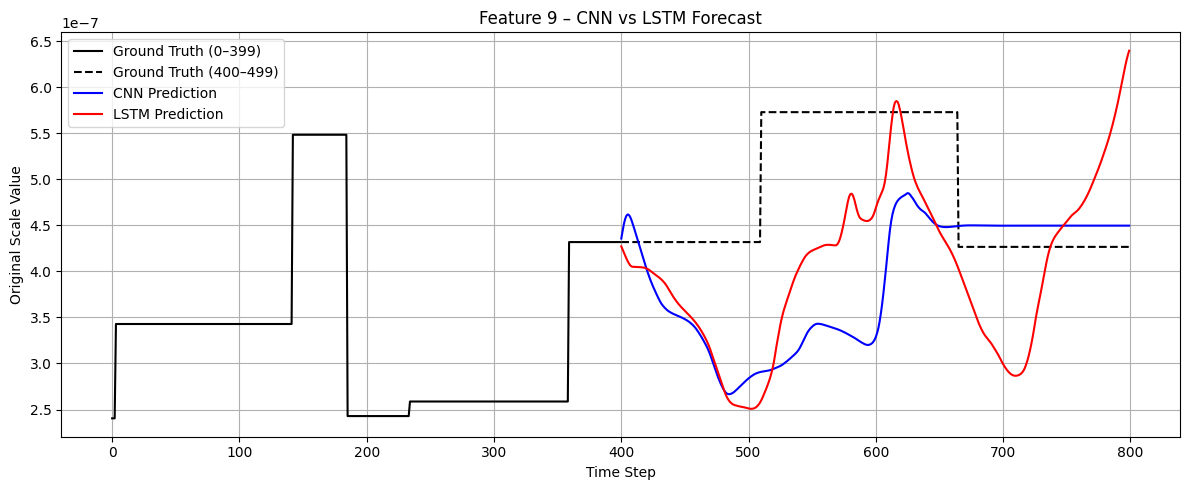

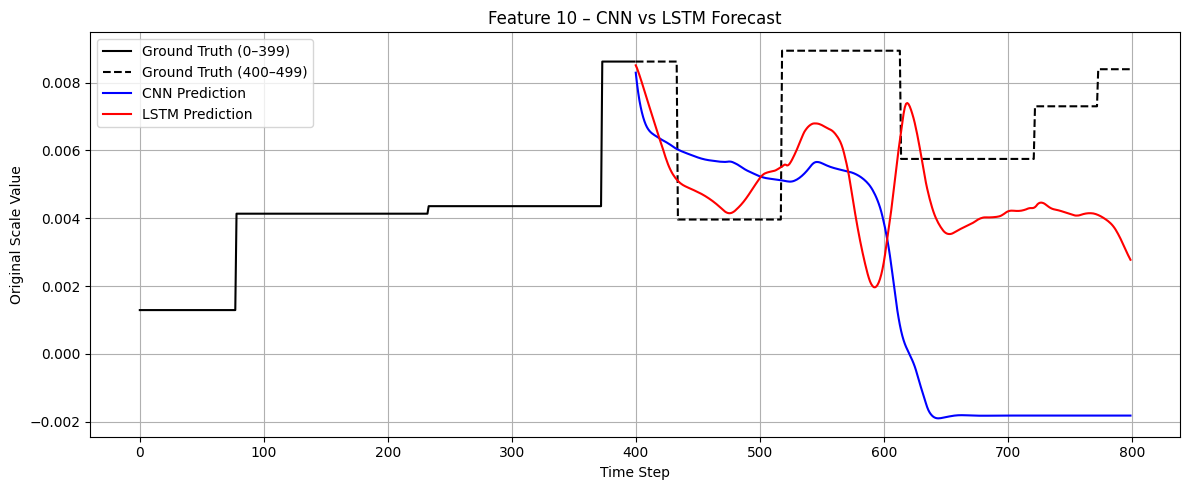

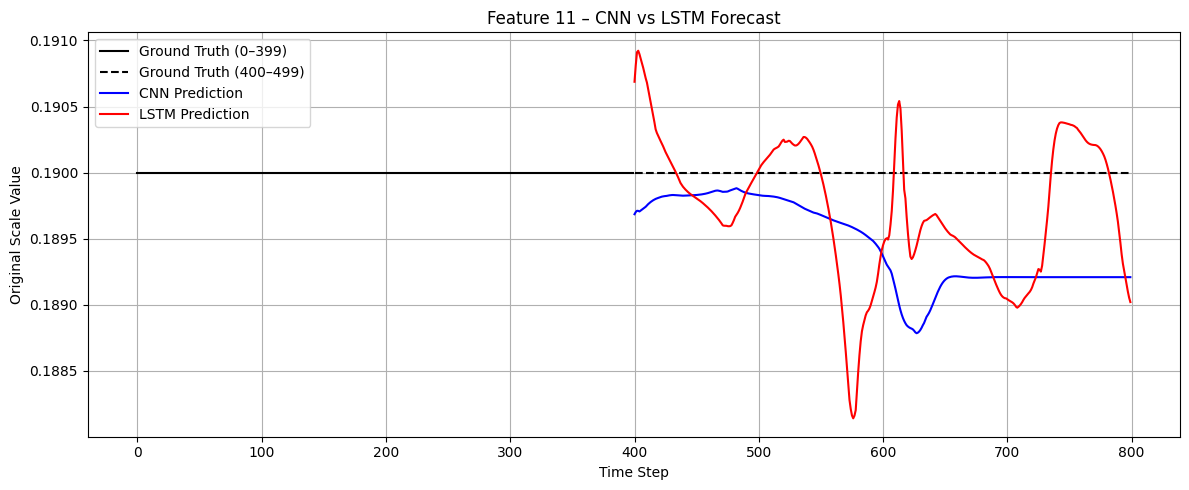

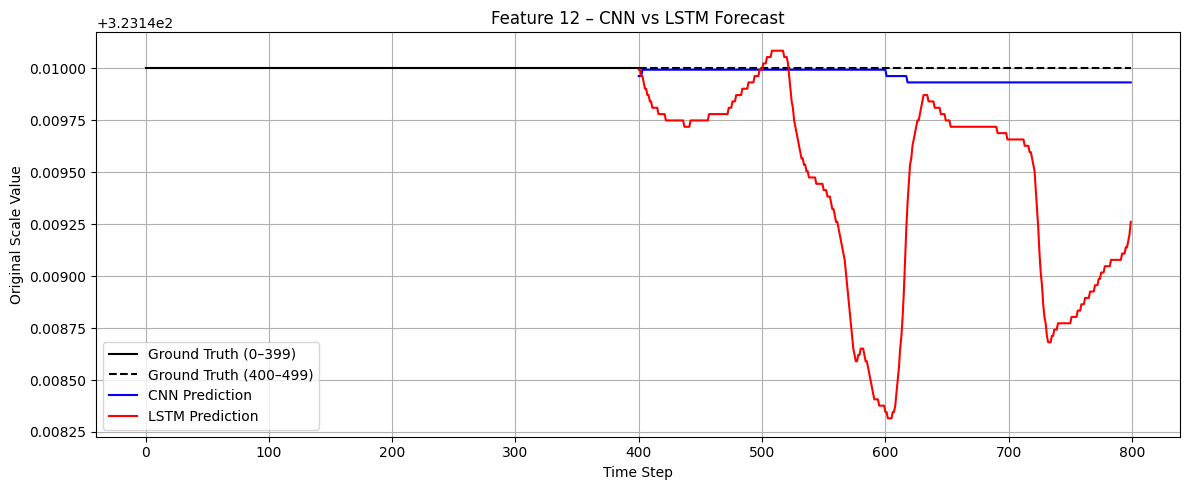

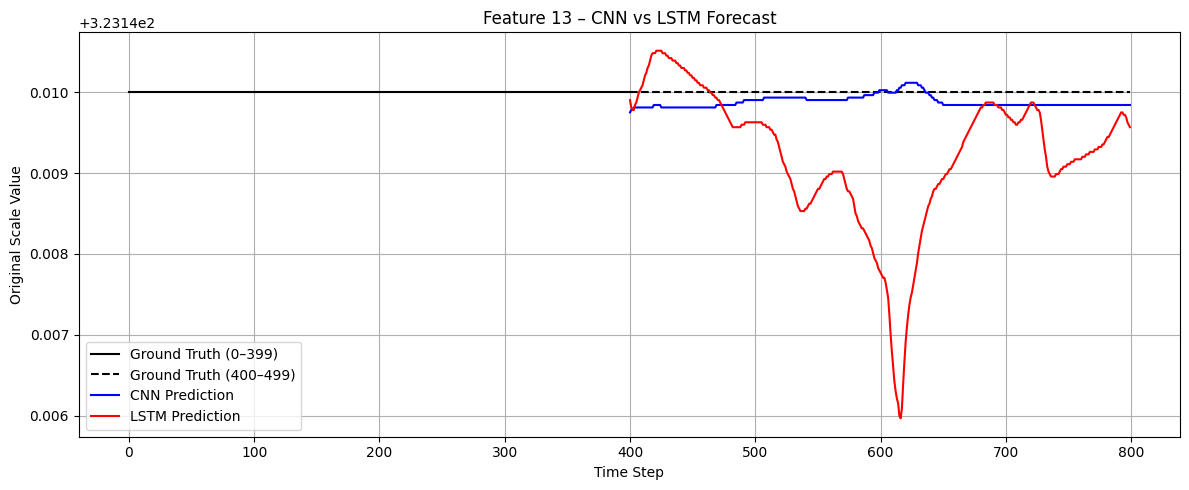

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# --- Configuration ---
FILE_PATH = 'Data/file_15229.txt'
T = 10                   # Number of past steps used for prediction
N_PREDICT = 400          # Steps to forecast
SEED_LEN = 400           # Seed steps used from actual data

CNN_MODEL_PATH = 'forecast_cluster1_cnn.keras'
LSTM_MODEL_PATH = 'forecast_cluster1_lstm.keras'

# --- Load models ---
cnn_model = load_model(CNN_MODEL_PATH)
lstm_model = load_model(LSTM_MODEL_PATH)
print("✅ Models loaded")

# --- Load and preprocess file ---
df = pd.read_csv(FILE_PATH, sep=None, engine='python', header=0)
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# Ensure we have enough rows
if df.shape[1] > 13:
    df = df.iloc[:, -13:]
elif df.shape[1] < 13:
    raise ValueError("⛔ File has fewer than 13 columns after cleaning.")
if df.shape[0] < SEED_LEN + N_PREDICT:
    raise ValueError("⛔ File has fewer than 500 usable rows.")

data = df.values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# --- Prepare seed + ground truth ---
seed_seq = data_scaled[:SEED_LEN].copy()
true_future = data_scaled[SEED_LEN:SEED_LEN + N_PREDICT]  # 100 steps

# --- Prediction function ---
def predict_future(model, seed_seq, t, n_steps):
    preds = []
    current_seq = seed_seq[-t:].copy()
    for _ in range(n_steps):
        input_seq = current_seq.reshape(1, t, 13)
        pred = model.predict(input_seq, verbose=0)
        preds.append(pred[0])
        current_seq = np.vstack([current_seq[1:], pred[0]])
    return np.array(preds)

# --- Predict using both models ---
pred_cnn_scaled = predict_future(cnn_model, seed_seq, T, N_PREDICT)
pred_lstm_scaled = predict_future(lstm_model, seed_seq, T, N_PREDICT)

# --- Inverse transform everything ---
seed_orig = scaler.inverse_transform(seed_seq)
true_future_orig = scaler.inverse_transform(true_future)
pred_cnn_orig = scaler.inverse_transform(pred_cnn_scaled)
pred_lstm_orig = scaler.inverse_transform(pred_lstm_scaled)

# --- Plot 500-step timeline for each feature ---
for i in range(13):
    plt.figure(figsize=(12, 5))
    # Actual first 400
    plt.plot(range(SEED_LEN), seed_orig[:, i], label='Ground Truth (0–399)', color='black')
    # Actual future
    plt.plot(range(SEED_LEN, SEED_LEN + N_PREDICT), true_future_orig[:, i], label='Ground Truth (400–499)', color='black', linestyle='--')
    # CNN predicted
    plt.plot(range(SEED_LEN, SEED_LEN + N_PREDICT), pred_cnn_orig[:, i], label='CNN Prediction', color='blue')
    # LSTM predicted
    plt.plot(range(SEED_LEN, SEED_LEN + N_PREDICT), pred_lstm_orig[:, i], label='LSTM Prediction', color='red')

    plt.title(f'Feature {i+1} – CNN vs LSTM Forecast')
    plt.xlabel('Time Step')
    plt.ylabel('Original Scale Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from tensorflow.keras.models import load_model

# --- Configuration ---
FILE_PATH = 'Data/file_15229.txt'
T = 10                   # Number of past steps used for prediction
N_PREDICT = 100          # Steps to forecast
SEED_LEN = 600           # Seed steps used from actual data

CNN_MODEL_PATH = 'forecast_cluster1_cnn.keras'
LSTM_MODEL_PATH = 'forecast_cluster1_lstm.keras'

# --- Load models ---
cnn_model = load_model(CNN_MODEL_PATH)
lstm_model = load_model(LSTM_MODEL_PATH)
print("✅ Models loaded")

# --- Load and preprocess file ---
df = pd.read_csv(FILE_PATH, sep=None, engine='python', header=0)
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# Ensure proper column count
if df.shape[1] > 13:
    df = df.iloc[:, -13:]
elif df.shape[1] < 13:
    raise ValueError("⛔ File has fewer than 13 columns after cleaning.")

# --- Remove outlier rows based on Z-score ---
z_scores = np.abs(zscore(df))
df_clean = df[(z_scores < 3.0).all(axis=1)]

print(f"✅ Rows before outlier removal: {len(df)}")
print(f"✅ Rows after outlier removal:  {len(df_clean)}")

if len(df_clean) < SEED_LEN + N_PREDICT:
    raise ValueError("⛔ Not enough clean rows (need at least 500 after outlier removal).")

data = df_clean.values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# --- Prepare seed + ground truth ---
seed_seq = data_scaled[:SEED_LEN].copy()
true_future = data_scaled[SEED_LEN:SEED_LEN + N_PREDICT]

# --- Prediction function ---
def predict_future(model, seed_seq, t, n_steps):
    preds = []
    current_seq = seed_seq[-t:].copy()
    for _ in range(n_steps):
        input_seq = current_seq.reshape(1, t, 13)
        pred = model.predict(input_seq, verbose=0)
        preds.append(pred[0])
        current_seq = np.vstack([current_seq[1:], pred[0]])
    return np.array(preds)

# --- Predict using both models ---
pred_cnn_scaled = predict_future(cnn_model, seed_seq, T, N_PREDICT)
pred_lstm_scaled = predict_future(lstm_model, seed_seq, T, N_PREDICT)

# --- Inverse transform everything ---
seed_orig = scaler.inverse_transform(seed_seq)
true_future_orig = scaler.inverse_transform(true_future)
pred_cnn_orig = scaler.inverse_transform(pred_cnn_scaled)
pred_lstm_orig = scaler.inverse_transform(pred_lstm_scaled)

# --- Plot 500-step timeline for each feature ---
for i in range(13):
    plt.figure(figsize=(12, 5))
    # Actual first 400
    plt.plot(range(SEED_LEN), seed_orig[:, i], label='Ground Truth (0–399)', color='black')
    # Actual future
    plt.plot(range(SEED_LEN, SEED_LEN + N_PREDICT), true_future_orig[:, i], label='Ground Truth (400–499)', color='black', linestyle='--')
    # CNN predicted
    plt.plot(range(SEED_LEN, SEED_LEN + N_PREDICT), pred_cnn_orig[:, i], label='CNN Prediction', color='blue')
    # LSTM predicted
    plt.plot(range(SEED_LEN, SEED_LEN + N_PREDICT), pred_lstm_orig[:, i], label='LSTM Prediction', color='red')

    plt.title(f'Feature {i+1} – CNN vs LSTM Forecast')
    plt.xlabel('Time Step')
    plt.ylabel('Original Scale Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

✅ Models loaded
✅ Rows before outlier removal: 1000
✅ Rows after outlier removal:  0


ValueError: ⛔ Not enough clean rows (need at least 500 after outlier removal).